# Mini project --> Stock analysis

```
pip install yfinance pandas numpy matplotlib scikit-learn ta-lib
```

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [3]:


class StockAnalysisTool:
    def __init__(self, symbol, period="1y"):
        self.symbol = symbol
        self.period = period
        self.data = None
        self.support_levels = []
        self.resistance_levels = []
        
    def fetch_data(self):
        """Fetch stock data from Yahoo Finance"""
        try:
            stock = yf.Ticker(self.symbol)
            self.data = stock.history(period=self.period)
            if self.data.empty:
                raise ValueError(f"No data found for symbol {self.symbol}")
            print(f"Successfully fetched data for {self.symbol}")
            return True
        except Exception as e:
            print(f"Error fetching data: {e}")
            return False
    
    def calculate_moving_averages(self, windows=[20, 50, 200]):
        """Calculate multiple moving averages"""
        for window in windows:
            self.data[f'MA_{window}'] = self.data['Close'].rolling(window=window).mean()
        return self.data
    
    def find_support_resistance(self, window=20, threshold=0.02):
        """
        Find support and resistance levels using local minima and maxima
        """
        self.support_levels = []
        self.resistance_levels = []
        
        highs = self.data['High']
        lows = self.data['Low']
        
        # Find local minima (support) and maxima (resistance)
        for i in range(window, len(self.data)-window):
            # Support levels (local minima)
            if all(lows[i] <= lows[i-j] for j in range(1, window+1)) and \
               all(lows[i] <= lows[i+j] for j in range(1, window+1)):
                support_level = lows[i]
                # Check if this level is significantly different from existing ones
                if not any(abs(support_level - level) / level < threshold 
                          for level in self.support_levels):
                    self.support_levels.append(support_level)
            
            # Resistance levels (local maxima)
            if all(highs[i] >= highs[i-j] for j in range(1, window+1)) and \
               all(highs[i] >= highs[i+j] for j in range(1, window+1)):
                resistance_level = highs[i]
                if not any(abs(resistance_level - level) / level < threshold 
                          for level in self.resistance_levels):
                    self.resistance_levels.append(resistance_level)
        
        return self.support_levels, self.resistance_levels
    
    def identify_order_blocks(self, lookback_period=10):
        """
        Identify order blocks - areas where big players enter positions
        Order blocks typically occur after strong moves and consolidation
        """
        order_blocks = []
        
        for i in range(lookback_period, len(self.data)-5):
            # Look for strong momentum candles
            current_candle = self.data.iloc[i]
            prev_candle = self.data.iloc[i-1]
            
            # Calculate candle properties
            body_size = abs(current_candle['Close'] - current_candle['Open'])
            range_size = current_candle['High'] - current_candle['Low']
            body_ratio = body_size / range_size if range_size > 0 else 0
            
            # Strong momentum candle criteria
            is_strong_bullish = (body_ratio > 0.6 and 
                                current_candle['Close'] > current_candle['Open'] and
                                current_candle['Close'] > prev_candle['High'])
            
            is_strong_bearish = (body_ratio > 0.6 and 
                                current_candle['Close'] < current_candle['Open'] and
                                current_candle['Close'] < prev_candle['Low'])
            
            if is_strong_bullish or is_strong_bearish:
                # The order block is the range of the strong candle
                order_block = {
                    'date': self.data.index[i],
                    'high': current_candle['High'],
                    'low': current_candle['Low'],
                    'type': 'bullish' if is_strong_bullish else 'bearish',
                    'strength': body_ratio
                }
                order_blocks.append(order_block)
        
        return order_blocks
    
    def calculate_volume_profile(self, price_bins=20):
        """
        Calculate volume profile - distribution of volume at different price levels
        """
        # Create price bins
        min_price = self.data['Low'].min()
        max_price = self.data['High'].max()
        bin_size = (max_price - min_price) / price_bins
        
        volume_profile = {}
        
        for i in range(price_bins):
            price_level_low = min_price + (i * bin_size)
            price_level_high = min_price + ((i + 1) * bin_size)
            price_level_mid = (price_level_low + price_level_high) / 2
            
            # Filter data for this price range
            mask = (self.data['Low'] >= price_level_low) & (self.data['High'] <= price_level_high)
            volume_at_level = self.data[mask]['Volume'].sum()
            
            volume_profile[price_level_mid] = volume_at_level
        
        return volume_profile
    
    def find_high_volume_nodes(self, volume_profile, threshold_ratio=0.7):
        """
        Find price levels with significantly high volume (High Volume Nodes - HVN)
        """
        if not volume_profile:
            return []
        
        max_volume = max(volume_profile.values())
        threshold = max_volume * threshold_ratio
        
        high_volume_nodes = {price: volume for price, volume in volume_profile.items() 
                           if volume >= threshold}
        
        return high_volume_nodes
    
    def analyze_trend(self):
        """
        Simple trend analysis using moving averages
        """
        if 'MA_20' not in self.data.columns or 'MA_50' not in self.data.columns:
            self.calculate_moving_averages()
        
        latest_data = self.data.iloc[-1]
        
        # Trend determination
        if latest_data['MA_20'] > latest_data['MA_50'] and latest_data['Close'] > latest_data['MA_20']:
            trend = "Strong Uptrend"
        elif latest_data['MA_20'] > latest_data['MA_50']:
            trend = "Moderate Uptrend"
        elif latest_data['MA_20'] < latest_data['MA_50'] and latest_data['Close'] < latest_data['MA_20']:
            trend = "Strong Downtrend"
        elif latest_data['MA_20'] < latest_data['MA_50']:
            trend = "Moderate Downtrend"
        else:
            trend = "Sideways/Ranging"
        
        return trend
    
    def generate_signals(self):
        """
        Generate trading signals based on multiple indicators
        """
        signals = []
        
        # Fetch latest data
        latest = self.data.iloc[-1]
        prev = self.data.iloc[-2]
        
        # Moving Average Signals
        if 'MA_20' in self.data.columns:
            if latest['Close'] > latest['MA_20'] and prev['Close'] <= prev['MA_20']:
                signals.append("BUY - Price crossed above 20MA")
            elif latest['Close'] < latest['MA_20'] and prev['Close'] >= prev['MA_20']:
                signals.append("SELL - Price crossed below 20MA")
        
        # Support/Resistance Signals
        current_price = latest['Close']
        support_hit = any(abs(current_price - level) / level < 0.01 for level in self.support_levels)
        resistance_hit = any(abs(current_price - level) / level < 0.01 for level in self.resistance_levels)
        
        if support_hit:
            signals.append("Potential BUY - Near support level")
        if resistance_hit:
            signals.append("Potential SELL - Near resistance level")
        
        # Volume analysis
        avg_volume = self.data['Volume'].mean()
        if latest['Volume'] > avg_volume * 1.5:
            signals.append("High volume detected - confirm direction")
        
        return signals if signals else ["No strong signals - Wait for confirmation"]
    
    def create_comprehensive_report(self):
        """Generate a complete analysis report"""
        if self.data is None:
            if not self.fetch_data():
                return "Failed to fetch data"
        
        # Calculate all indicators
        self.calculate_moving_averages()
        support, resistance = self.find_support_resistance()
        order_blocks = self.identify_order_blocks()
        volume_profile = self.calculate_volume_profile()
        high_volume_nodes = self.find_high_volume_nodes(volume_profile)
        trend = self.analyze_trend()
        signals = self.generate_signals()
        
        # Create report
        report = {
            'symbol': self.symbol,
            'current_price': self.data['Close'].iloc[-1],
            'trend': trend,
            'support_levels': sorted(support)[-5:],  # Top 5 support levels
            'resistance_levels': sorted(resistance)[:5],  # Top 5 resistance levels
            'order_blocks_found': len(order_blocks),
            'recent_order_blocks': order_blocks[-3:] if order_blocks else [],
            'high_volume_nodes': list(high_volume_nodes.keys()),
            'trading_signals': signals,
            'volume_analysis': 'High volume concentration at: ' + ', '.join([f"${price:.2f}" 
                              for price in list(high_volume_nodes.keys())[:3]])
        }
        
        return report
    
    def plot_analysis(self, days_to_plot=90):
        """Create a comprehensive plot of the analysis"""
        if self.data is None:
            self.fetch_data()
        
        # Calculate indicators if not already done
        if 'MA_20' not in self.data.columns:
            self.calculate_moving_averages()
        
        if not self.support_levels or not self.resistance_levels:
            self.find_support_resistance()
        
        # Get recent data
        recent_data = self.data.tail(days_to_plot)
        
        plt.figure(figsize=(15, 10))
        
        # Plot price and moving averages
        plt.subplot(2, 1, 1)
        plt.plot(recent_data.index, recent_data['Close'], label='Close Price', linewidth=2, color='black')
        plt.plot(recent_data.index, recent_data['MA_20'], label='20 MA', alpha=0.7)
        plt.plot(recent_data.index, recent_data['MA_50'], label='50 MA', alpha=0.7)
        
        # Plot support and resistance levels
        current_min = recent_data['Low'].min()
        current_max = recent_data['High'].max()
        
        for level in self.support_levels:
            if current_min <= level <= current_max:
                plt.axhline(y=level, color='green', linestyle='--', alpha=0.5, label='Support' if level == self.support_levels[0] else "")
        
        for level in self.resistance_levels:
            if current_min <= level <= current_max:
                plt.axhline(y=level, color='red', linestyle='--', alpha=0.5, label='Resistance' if level == self.resistance_levels[0] else "")
        
        plt.title(f'{self.symbol} Technical Analysis')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot volume
        plt.subplot(2, 1, 2)
        plt.bar(recent_data.index, recent_data['Volume'], alpha=0.7, color='blue')
        plt.title('Volume')
        plt.ylabel('Volume')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


Successfully fetched data for AAPL
=== STOCK ANALYSIS REPORT ===
Symbol: AAPL
Current Price: $259.58
Trend: Strong Uptrend

Support Levels: ['$201.27']
Resistance Levels: ['$215.98']

Trading Signals:
  - No strong signals - Wait for confirmation

High volume concentration at: $201.84


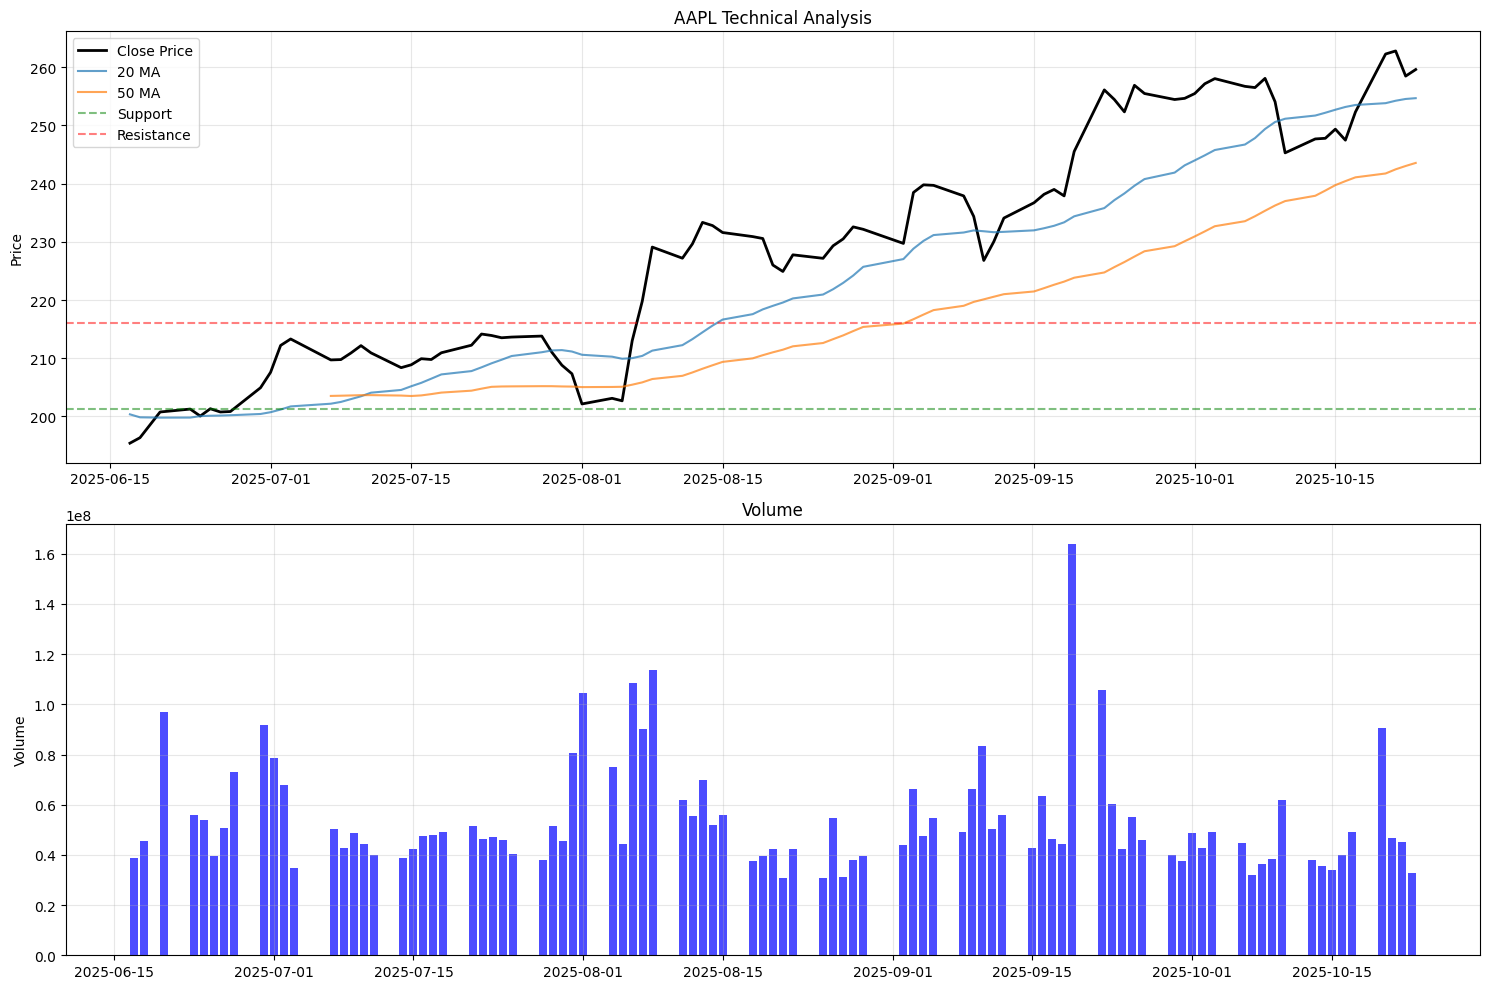

In [4]:

# Example usage and testing
def main():
    # Example with Apple stock
    analyzer = StockAnalysisTool("AAPL", "6mo")
    
    # Generate comprehensive report
    report = analyzer.create_comprehensive_report()
    
    print("=== STOCK ANALYSIS REPORT ===")
    print(f"Symbol: {report['symbol']}")
    print(f"Current Price: ${report['current_price']:.2f}")
    print(f"Trend: {report['trend']}")
    print(f"\nSupport Levels: {[f'${level:.2f}' for level in report['support_levels']]}")
    print(f"Resistance Levels: {[f'${level:.2f}' for level in report['resistance_levels']]}")
    print(f"\nTrading Signals:")
    for signal in report['trading_signals']:
        print(f"  - {signal}")
    print(f"\n{report['volume_analysis']}")
    
    # Plot the analysis
    analyzer.plot_analysis()

if __name__ == "__main__":
    main()

In [5]:
class AdvancedPatterns:
    def __init__(self, stock_analyzer):
        self.analyzer = stock_analyzer
        self.data = stock_analyzer.data
    
    def detect_double_top_bottom(self, window=30):
        """Detect double top and double bottom patterns"""
        patterns = []
        data = self.data['Close'].values
        
        for i in range(window, len(data) - window):
            # Look for potential double top
            left_top = np.argmax(data[i-window:i]) + (i - window)
            right_top = np.argmax(data[i:i+window]) + i
            
            if abs(data[left_top] - data[right_top]) / data[left_top] < 0.02:  # Within 2%
                patterns.append({
                    'type': 'double_top',
                    'confirmation_level': min(data[i-window:i+window]),
                    'neckline': (data[left_top] + data[right_top]) / 2 * 0.98
                })
            
            # Look for potential double bottom
            left_bottom = np.argmin(data[i-window:i]) + (i - window)
            right_bottom = np.argmin(data[i:i+window]) + i
            
            if abs(data[left_bottom] - data[right_bottom]) / data[left_bottom] < 0.02:
                patterns.append({
                    'type': 'double_bottom',
                    'confirmation_level': max(data[i-window:i+window]),
                    'neckline': (data[left_bottom] + data[right_bottom]) / 2 * 1.02
                })
        
        return patterns
    
    def find_breakouts(self, consolidation_period=20, breakout_threshold=0.03):
        """Identify price breakouts from consolidation"""
        breakouts = []
        
        for i in range(consolidation_period, len(self.data)):
            # Check consolidation period
            consolidation_data = self.data.iloc[i-consolidation_period:i]
            high_range = consolidation_data['High'].max()
            low_range = consolidation_data['Low'].min()
            range_size = (high_range - low_range) / low_range
            
            # If range is small (consolidation)
            if range_size < 0.05:  # Less than 5% range
                current_close = self.data.iloc[i]['Close']
                # Check for breakout
                if current_close > high_range * (1 + breakout_threshold):
                    breakouts.append({
                        'type': 'bullish_breakout',
                        'date': self.data.index[i],
                        'breakout_level': high_range,
                        'current_price': current_close
                    })
                elif current_close < low_range * (1 - breakout_threshold):
                    breakouts.append({
                        'type': 'bearish_breakout',
                        'date': self.data.index[i],
                        'breakout_level': low_range,
                        'current_price': current_close
                    })
        
        return breakouts

In [6]:
# Multiple stock analysis
def analyze_multiple_stocks(symbols):
    results = {}
    
    for symbol in symbols:
        print(f"\nAnalyzing {symbol}...")
        analyzer = StockAnalysisTool(symbol, "1y")
        report = analyzer.create_comprehensive_report()
        results[symbol] = report
        
        # Print key findings
        print(f"  Trend: {report['trend']}")
        print(f"  Signals: {report['trading_signals'][:2]}")
    
    return results



Successfully fetched data for TSLA
symbol: TSLA
current_price: 448.9800109863281
trend: Strong Uptrend
support_levels: []
resistance_levels: [np.float64(367.7099914550781)]
order_blocks_found: 31
recent_order_blocks: [{'date': Timestamp('2025-10-06 00:00:00-0400', tz='America/New_York'), 'high': np.float64(453.54998779296875), 'low': np.float64(436.69000244140625), 'type': 'bullish', 'strength': np.float64(0.7414004069013952)}, {'date': Timestamp('2025-10-07 00:00:00-0400', tz='America/New_York'), 'high': np.float64(452.67999267578125), 'low': np.float64(432.45001220703125), 'type': 'bearish', 'strength': np.float64(0.7281277907846782)}, {'date': Timestamp('2025-10-10 00:00:00-0400', tz='America/New_York'), 'high': np.float64(443.1300048828125), 'low': np.float64(411.45001220703125), 'type': 'bearish', 'strength': np.float64(0.7275891300368946)}]
high_volume_nodes: [np.float64(321.2037479400635)]
trading_signals: ['No strong signals - Wait for confirmation']
volume_analysis: High volum

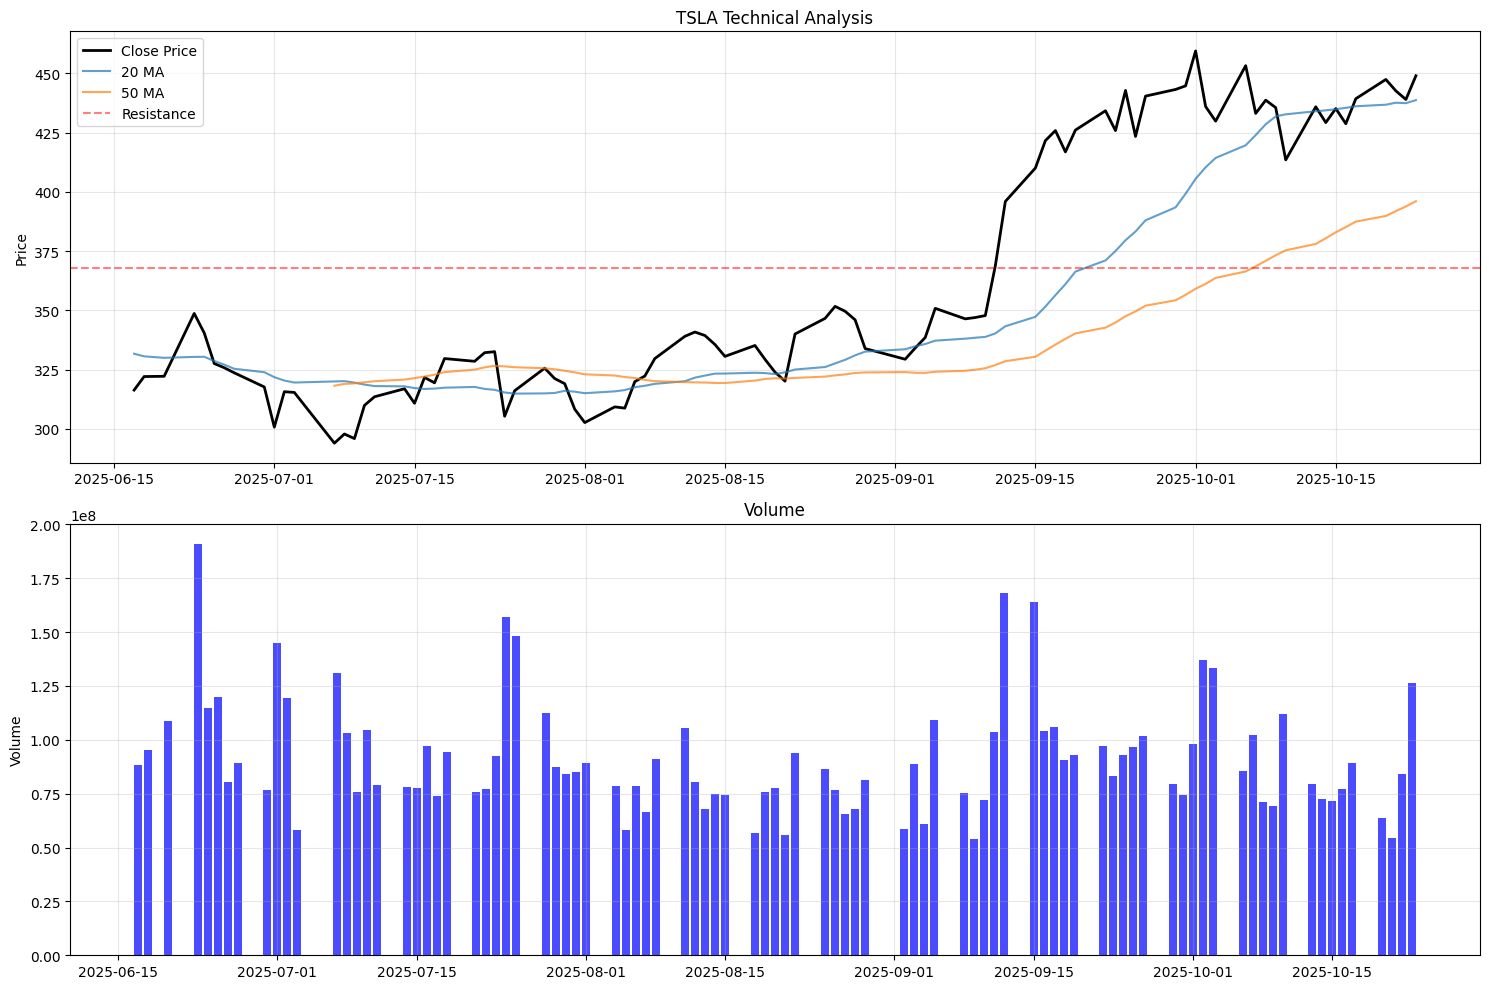


Analyzing AAPL...
Successfully fetched data for AAPL
  Trend: Strong Uptrend
  Signals: ['Potential SELL - Near resistance level']

Analyzing GOOGL...
Successfully fetched data for GOOGL
  Trend: Strong Uptrend
  Signals: ['No strong signals - Wait for confirmation']

Analyzing MSFT...
Successfully fetched data for MSFT
  Trend: Strong Uptrend
  Signals: ['No strong signals - Wait for confirmation']

Analyzing AMZN...
Successfully fetched data for AMZN
  Trend: Moderate Downtrend
  Signals: ['BUY - Price crossed above 20MA']


In [7]:
# Single stock analysis
analyzer = StockAnalysisTool("TSLA", "6mo")
report = analyzer.create_comprehensive_report()
    
    # Print detailed report
for key, value in report.items():
    print(f"{key}: {value}")
    
    # Plot the analysis
analyzer.plot_analysis()
    
    # Multiple stocks
stocks = ["AAPL", "GOOGL", "MSFT", "AMZN"]
results = analyze_multiple_stocks(stocks)

---
### Update

Successfully fetched data for AAPL
=== STOCK ANALYSIS REPORT ===
Symbol: AAPL
Current Price: $259.58
Trend: Strong Uptrend

Support Levels: ['$201.27']
Resistance Levels: ['$215.98']

Trading Signals:
  - No strong signals - Wait for confirmation

High volume concentration at: $201.84


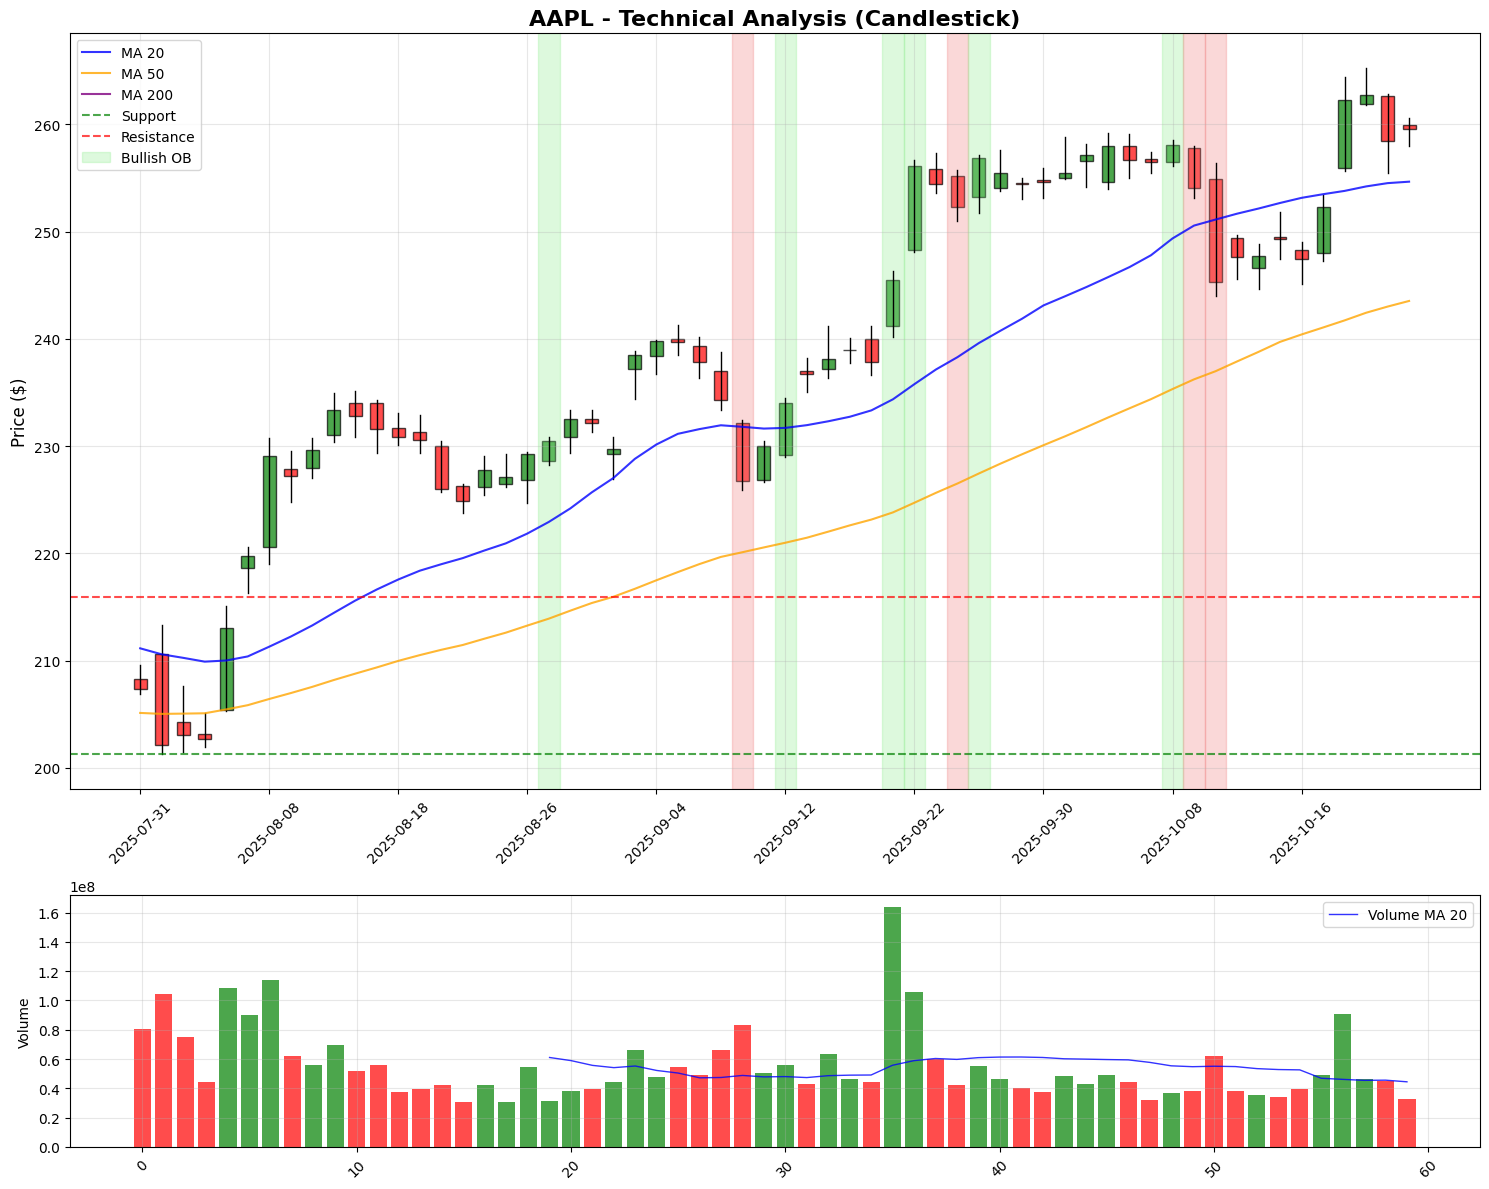

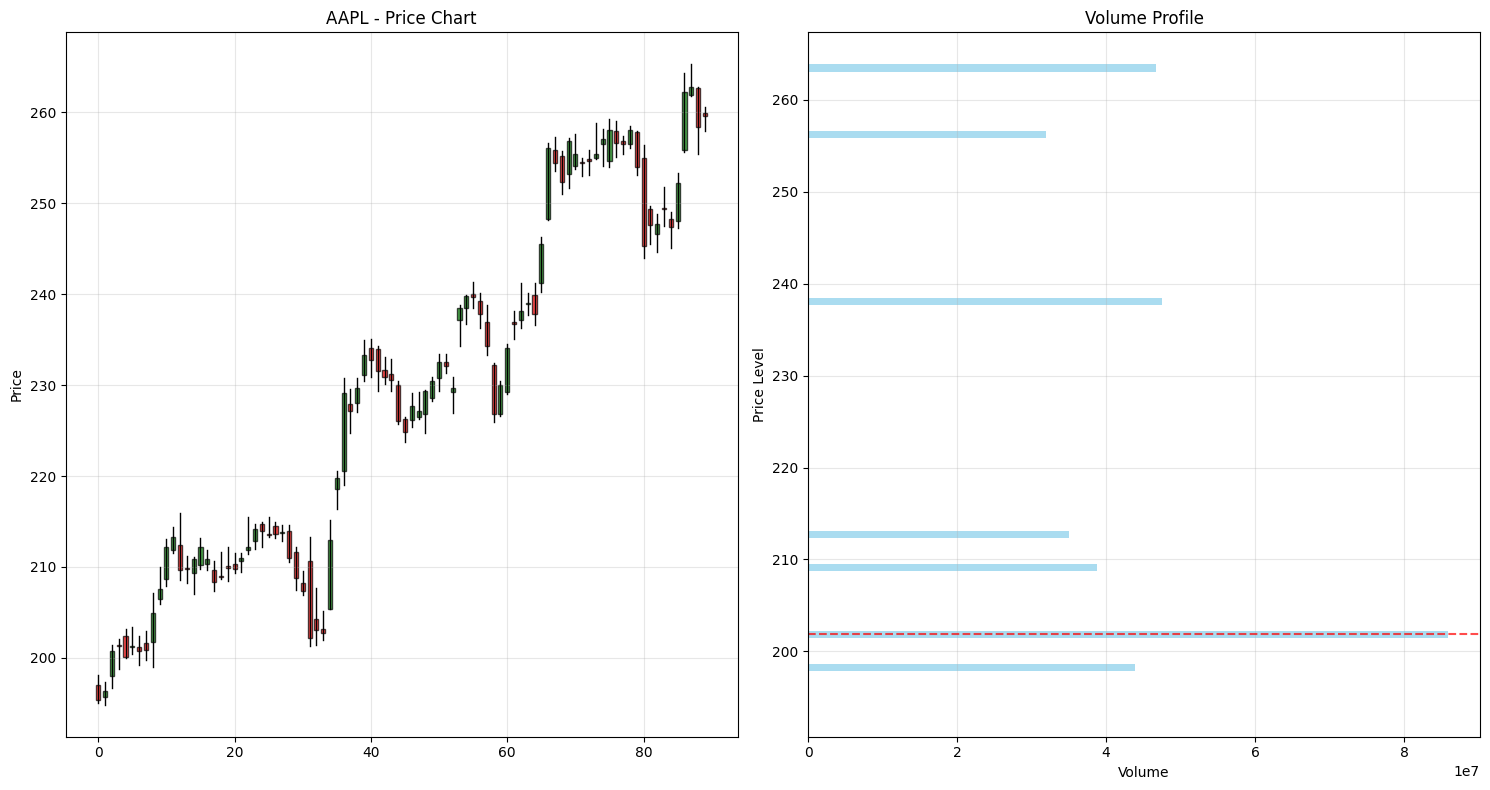

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class StockAnalysisTool:
    def __init__(self, symbol, period="1y"):
        self.symbol = symbol
        self.period = period
        self.data = None
        self.support_levels = []
        self.resistance_levels = []
        
    def fetch_data(self):
        """Fetch stock data from Yahoo Finance"""
        try:
            stock = yf.Ticker(self.symbol)
            self.data = stock.history(period=self.period)
            if self.data.empty:
                raise ValueError(f"No data found for symbol {self.symbol}")
            print(f"Successfully fetched data for {self.symbol}")
            return True
        except Exception as e:
            print(f"Error fetching data: {e}")
            return False
    
    def calculate_moving_averages(self, windows=[20, 50, 200]):
        """Calculate multiple moving averages"""
        for window in windows:
            self.data[f'MA_{window}'] = self.data['Close'].rolling(window=window).mean()
        return self.data
    
    def find_support_resistance(self, window=20, threshold=0.02):
        """
        Find support and resistance levels using local minima and maxima
        """
        self.support_levels = []
        self.resistance_levels = []
        
        highs = self.data['High']
        lows = self.data['Low']
        
        # Find local minima (support) and maxima (resistance)
        for i in range(window, len(self.data)-window):
            # Support levels (local minima)
            if all(lows[i] <= lows[i-j] for j in range(1, window+1)) and \
               all(lows[i] <= lows[i+j] for j in range(1, window+1)):
                support_level = lows[i]
                # Check if this level is significantly different from existing ones
                if not any(abs(support_level - level) / level < threshold 
                          for level in self.support_levels):
                    self.support_levels.append(support_level)
            
            # Resistance levels (local maxima)
            if all(highs[i] >= highs[i-j] for j in range(1, window+1)) and \
               all(highs[i] >= highs[i+j] for j in range(1, window+1)):
                resistance_level = highs[i]
                if not any(abs(resistance_level - level) / level < threshold 
                          for level in self.resistance_levels):
                    self.resistance_levels.append(resistance_level)
        
        return self.support_levels, self.resistance_levels
    
    def identify_order_blocks(self, lookback_period=10):
        """
        Identify order blocks - areas where big players enter positions
        """
        order_blocks = []
        
        for i in range(lookback_period, len(self.data)-5):
            current_candle = self.data.iloc[i]
            prev_candle = self.data.iloc[i-1]
            
            # Calculate candle properties
            body_size = abs(current_candle['Close'] - current_candle['Open'])
            range_size = current_candle['High'] - current_candle['Low']
            body_ratio = body_size / range_size if range_size > 0 else 0
            
            # Strong momentum candle criteria
            is_strong_bullish = (body_ratio > 0.6 and 
                                current_candle['Close'] > current_candle['Open'] and
                                current_candle['Close'] > prev_candle['High'])
            
            is_strong_bearish = (body_ratio > 0.6 and 
                                current_candle['Close'] < current_candle['Open'] and
                                current_candle['Close'] < prev_candle['Low'])
            
            if is_strong_bullish or is_strong_bearish:
                order_block = {
                    'date': self.data.index[i],
                    'high': current_candle['High'],
                    'low': current_candle['Low'],
                    'type': 'bullish' if is_strong_bullish else 'bearish',
                    'strength': body_ratio
                }
                order_blocks.append(order_block)
        
        return order_blocks
    
    def calculate_volume_profile(self, price_bins=20):
        """Calculate volume profile"""
        min_price = self.data['Low'].min()
        max_price = self.data['High'].max()
        bin_size = (max_price - min_price) / price_bins
        
        volume_profile = {}
        
        for i in range(price_bins):
            price_level_low = min_price + (i * bin_size)
            price_level_high = min_price + ((i + 1) * bin_size)
            price_level_mid = (price_level_low + price_level_high) / 2
            
            mask = (self.data['Low'] >= price_level_low) & (self.data['High'] <= price_level_high)
            volume_at_level = self.data[mask]['Volume'].sum()
            
            volume_profile[price_level_mid] = volume_at_level
        
        return volume_profile
    
    def find_high_volume_nodes(self, volume_profile, threshold_ratio=0.7):
        """Find High Volume Nodes"""
        if not volume_profile:
            return []
        
        max_volume = max(volume_profile.values())
        threshold = max_volume * threshold_ratio
        
        high_volume_nodes = {price: volume for price, volume in volume_profile.items() 
                           if volume >= threshold}
        
        return high_volume_nodes
    
    def analyze_trend(self):
        """Simple trend analysis using moving averages"""
        if 'MA_20' not in self.data.columns or 'MA_50' not in self.data.columns:
            self.calculate_moving_averages()
        
        latest_data = self.data.iloc[-1]
        
        if latest_data['MA_20'] > latest_data['MA_50'] and latest_data['Close'] > latest_data['MA_20']:
            trend = "Strong Uptrend"
        elif latest_data['MA_20'] > latest_data['MA_50']:
            trend = "Moderate Uptrend"
        elif latest_data['MA_20'] < latest_data['MA_50'] and latest_data['Close'] < latest_data['MA_20']:
            trend = "Strong Downtrend"
        elif latest_data['MA_20'] < latest_data['MA_50']:
            trend = "Moderate Downtrend"
        else:
            trend = "Sideways/Ranging"
        
        return trend
    
    def generate_signals(self):
        """Generate trading signals based on multiple indicators"""
        signals = []
        
        latest = self.data.iloc[-1]
        prev = self.data.iloc[-2]
        
        # Moving Average Signals
        if 'MA_20' in self.data.columns:
            if latest['Close'] > latest['MA_20'] and prev['Close'] <= prev['MA_20']:
                signals.append("BUY - Price crossed above 20MA")
            elif latest['Close'] < latest['MA_20'] and prev['Close'] >= prev['MA_20']:
                signals.append("SELL - Price crossed below 20MA")
        
        # Support/Resistance Signals
        current_price = latest['Close']
        support_hit = any(abs(current_price - level) / level < 0.01 for level in self.support_levels)
        resistance_hit = any(abs(current_price - level) / level < 0.01 for level in self.resistance_levels)
        
        if support_hit:
            signals.append("Potential BUY - Near support level")
        if resistance_hit:
            signals.append("Potential SELL - Near resistance level")
        
        # Volume analysis
        avg_volume = self.data['Volume'].mean()
        if latest['Volume'] > avg_volume * 1.5:
            signals.append("High volume detected - confirm direction")
        
        return signals if signals else ["No strong signals - Wait for confirmation"]
    
    def create_comprehensive_report(self):
        """Generate a complete analysis report"""
        if self.data is None:
            if not self.fetch_data():
                return "Failed to fetch data"
        
        self.calculate_moving_averages()
        support, resistance = self.find_support_resistance()
        order_blocks = self.identify_order_blocks()
        volume_profile = self.calculate_volume_profile()
        high_volume_nodes = self.find_high_volume_nodes(volume_profile)
        trend = self.analyze_trend()
        signals = self.generate_signals()
        
        report = {
            'symbol': self.symbol,
            'current_price': self.data['Close'].iloc[-1],
            'trend': trend,
            'support_levels': sorted(support)[-5:],
            'resistance_levels': sorted(resistance)[:5],
            'order_blocks_found': len(order_blocks),
            'recent_order_blocks': order_blocks[-3:] if order_blocks else [],
            'high_volume_nodes': list(high_volume_nodes.keys()),
            'trading_signals': signals,
            'volume_analysis': 'High volume concentration at: ' + ', '.join([f"${price:.2f}" 
                              for price in list(high_volume_nodes.keys())[:3]])
        }
        
        return report

    def plot_candlestick_analysis(self, days_to_plot=90):
        """Create comprehensive candlestick chart with all analysis"""
        if self.data is None:
            self.fetch_data()
        
        # Calculate indicators if not already done
        if 'MA_20' not in self.data.columns:
            self.calculate_moving_averages()
        
        if not self.support_levels or not self.resistance_levels:
            self.find_support_resistance()
        
        # Get recent data
        recent_data = self.data.tail(days_to_plot)
        
        # Create the figure with subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), 
                                      gridspec_kw={'height_ratios': [3, 1]})
        
        # Plot candlesticks
        self._plot_candlesticks(ax1, recent_data)
        
        # Plot moving averages
        self._plot_moving_averages(ax1, recent_data)
        
        # Plot support and resistance
        self._plot_support_resistance(ax1, recent_data)
        
        # Plot order blocks
        order_blocks = self.identify_order_blocks()
        self._plot_order_blocks(ax1, order_blocks, recent_data)
        
        # Plot volume
        self._plot_volume(ax2, recent_data)
        
        # Format the chart
        self._format_chart(ax1, ax2, recent_data)
        
        plt.tight_layout()
        plt.show()
    
    def _plot_candlesticks(self, ax, data):
        """Plot candlestick chart"""
        # Calculate candle colors
        colors = ['green' if close >= open_val else 'red' 
                 for close, open_val in zip(data['Close'], data['Open'])]
        
        # Plot candlesticks
        for i, (idx, row) in enumerate(data.iterrows()):
            # Calculate candle dimensions
            open_val = row['Open']
            close_val = row['Close']
            high_val = row['High']
            low_val = row['Low']
            
            # Determine color
            color = 'green' if close_val >= open_val else 'red'
            
            # Plot high-low line
            ax.plot([i, i], [low_val, high_val], color='black', linewidth=1)
            
            # Plot body
            body_bottom = min(open_val, close_val)
            body_top = max(open_val, close_val)
            body_height = body_top - body_bottom
            
            if body_height > 0:
                rect = Rectangle((i-0.3, body_bottom), 0.6, body_height, 
                               facecolor=color, alpha=0.7, edgecolor='black')
                ax.add_patch(rect)
    
    def _plot_moving_averages(self, ax, data):
        """Plot moving averages"""
        ma_colors = ['blue', 'orange', 'purple']
        ma_windows = [20, 50, 200]
        
        for window, color in zip(ma_windows, ma_colors):
            if f'MA_{window}' in data.columns:
                ax.plot(range(len(data)), data[f'MA_{window}'], 
                       label=f'MA {window}', color=color, alpha=0.8, linewidth=1.5)
    
    def _plot_support_resistance(self, ax, data):
        """Plot support and resistance levels"""
        current_min = data['Low'].min()
        current_max = data['High'].max()
        
        # Plot support levels
        for i, level in enumerate(self.support_levels):
            if current_min <= level <= current_max:
                ax.axhline(y=level, color='green', linestyle='--', alpha=0.7, 
                          label='Support' if i == 0 else "")
        
        # Plot resistance levels
        for i, level in enumerate(self.resistance_levels):
            if current_min <= level <= current_max:
                ax.axhline(y=level, color='red', linestyle='--', alpha=0.7,
                          label='Resistance' if i == 0 else "")
    
    def _plot_order_blocks(self, ax, order_blocks, data):
        """Plot order blocks on the chart"""
        data_dates = list(data.index)
        
        for ob in order_blocks[-10:]:  # Plot last 10 order blocks
            if ob['date'] in data_dates:
                idx = data_dates.index(ob['date'])
                color = 'lightgreen' if ob['type'] == 'bullish' else 'lightcoral'
                alpha = 0.3
                
                # Highlight the order block area
                ax.axvspan(idx-0.5, idx+0.5, alpha=alpha, color=color,
                          label=f"{ob['type'].title()} OB" if ob == order_blocks[-10] else "")
    
    def _plot_volume(self, ax, data):
        """Plot volume bars"""
        colors = ['green' if close >= open_val else 'red' 
                 for close, open_val in zip(data['Close'], data['Open'])]
        
        ax.bar(range(len(data)), data['Volume'], color=colors, alpha=0.7)
        ax.set_ylabel('Volume')
        
        # Add moving average of volume
        volume_ma = data['Volume'].rolling(window=20).mean()
        ax.plot(range(len(data)), volume_ma, color='blue', alpha=0.8, 
               label='Volume MA 20', linewidth=1)
        ax.legend()
    
    def _format_chart(self, ax1, ax2, data):
        """Format the chart appearance"""
        # Set titles and labels
        ax1.set_title(f'{self.symbol} - Technical Analysis (Candlestick)', fontsize=16, fontweight='bold')
        ax1.set_ylabel('Price ($)', fontsize=12)
        
        # Set x-axis labels as dates
        ax1.set_xticks(range(0, len(data), max(1, len(data)//10)))
        ax1.set_xticklabels([date.strftime('%Y-%m-%d') for date in data.index[::max(1, len(data)//10)]])
        
        # Add grid and legend
        ax1.grid(True, alpha=0.3)
        ax2.grid(True, alpha=0.3)
        
        # Combine legends and avoid duplicates
        handles, labels = ax1.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax1.legend(by_label.values(), by_label.keys(), loc='upper left')
        
        # Rotate x-axis labels for better readability
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

    def plot_volume_profile(self, price_bins=20):
        """Plot volume profile separately"""
        volume_profile = self.calculate_volume_profile(price_bins)
        
        if not volume_profile:
            print("No volume profile data available")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
        
        # Plot price chart with volume profile
        recent_data = self.data.tail(90)
        self._plot_candlesticks(ax1, recent_data)
        ax1.set_title(f'{self.symbol} - Price Chart')
        ax1.set_ylabel('Price')
        ax1.grid(True, alpha=0.3)
        
        # Plot volume profile
        prices = list(volume_profile.keys())
        volumes = list(volume_profile.values())
        
        ax2.barh(prices, volumes, alpha=0.7, color='skyblue')
        ax2.set_xlabel('Volume')
        ax2.set_ylabel('Price Level')
        ax2.set_title('Volume Profile')
        ax2.grid(True, alpha=0.3)
        
        # Highlight high volume nodes
        hvn = self.find_high_volume_nodes(volume_profile)
        for price in hvn.keys():
            ax2.axhline(y=price, color='red', linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.show()

# Example usage with candlestick charts
def main():
    # Analyze Apple stock
    analyzer = StockAnalysisTool("AAPL", "6mo")
    
    # Generate comprehensive report
    report = analyzer.create_comprehensive_report()
    
    print("=== STOCK ANALYSIS REPORT ===")
    print(f"Symbol: {report['symbol']}")
    print(f"Current Price: ${report['current_price']:.2f}")
    print(f"Trend: {report['trend']}")
    print(f"\nSupport Levels: {[f'${level:.2f}' for level in report['support_levels']]}")
    print(f"Resistance Levels: {[f'${level:.2f}' for level in report['resistance_levels']]}")
    print(f"\nTrading Signals:")
    for signal in report['trading_signals']:
        print(f"  - {signal}")
    print(f"\n{report['volume_analysis']}")
    
    # Plot candlestick analysis
    analyzer.plot_candlestick_analysis(60)  # Last 60 days
    
    # Plot volume profile separately
    analyzer.plot_volume_profile()

# Advanced pattern detection with candlestick patterns
class CandlestickPatterns:
    def __init__(self, stock_analyzer):
        self.analyzer = stock_analyzer
        self.data = stock_analyzer.data
    
    def detect_doji(self, threshold=0.1):
        """Detect Doji candlestick patterns"""
        doji_patterns = []
        
        for i, (idx, row) in enumerate(self.data.iterrows()):
            body_size = abs(row['Close'] - row['Open'])
            total_range = row['High'] - row['Low']
            
            if total_range > 0 and (body_size / total_range) < threshold:
                doji_patterns.append({
                    'date': idx,
                    'type': 'doji',
                    'price': (row['High'] + row['Low']) / 2
                })
        
        return doji_patterns
    
    def detect_engulfing(self):
        """Detect Bullish/Bearish Engulfing patterns"""
        engulfing_patterns = []
        
        for i in range(1, len(self.data)):
            current = self.data.iloc[i]
            previous = self.data.iloc[i-1]
            
            # Bullish engulfing
            if (current['Close'] > current['Open'] and  # Current is bullish
                previous['Close'] < previous['Open'] and  # Previous is bearish
                current['Open'] < previous['Close'] and   # Current opens below previous close
                current['Close'] > previous['Open']):     # Current closes above previous open
                
                engulfing_patterns.append({
                    'date': self.data.index[i],
                    'type': 'bullish_engulfing',
                    'price': current['Close']
                })
            
            # Bearish engulfing
            elif (current['Close'] < current['Open'] and  # Current is bearish
                  previous['Close'] > previous['Open'] and  # Previous is bullish
                  current['Open'] > previous['Close'] and   # Current opens above previous close
                  current['Close'] < previous['Open']):     # Current closes below previous open
                
                engulfing_patterns.append({
                    'date': self.data.index[i],
                    'type': 'bearish_engulfing',
                    'price': current['Close']
                })
        
        return engulfing_patterns

if __name__ == "__main__":
    main()